In [1]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TEST_SIZE = 0.2
RANDOM_SEED = 2020
N_FOLD = 5

In [3]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# Interpretating feature importances using lgb

## without KFold

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_test, y_test)

dict_evals_result = {}
model = lgb.train(
    params = {
        "objective":"regression",
        "metric":"rmse",
        "verbosity": -1,
    },
    train_set = train_set,
    valid_sets = [train_set, valid_set],
    num_boost_round = 100,
    early_stopping_rounds = 5,
    verbose_eval = 10,
    evals_result = dict_evals_result
)

Training until validation scores don't improve for 5 rounds
[10]	training's rmse: 4.54663	valid_1's rmse: 5.72058
[20]	training's rmse: 3.18802	valid_1's rmse: 4.6596
[30]	training's rmse: 2.67034	valid_1's rmse: 4.28373
[40]	training's rmse: 2.37461	valid_1's rmse: 4.11099
[50]	training's rmse: 2.16227	valid_1's rmse: 3.97863
[60]	training's rmse: 1.96134	valid_1's rmse: 3.93859
[70]	training's rmse: 1.8071	valid_1's rmse: 3.9074
Early stopping, best iteration is:
[66]	training's rmse: 1.85508	valid_1's rmse: 3.89916


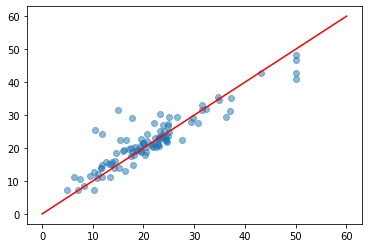

In [5]:
pred = model.predict(X_test)
plt.scatter(y_test, pred, alpha=0.5)
x_line = np.linspace(0, 60, 100)
plt.plot(x_line, x_line, color="red")
plt.show()

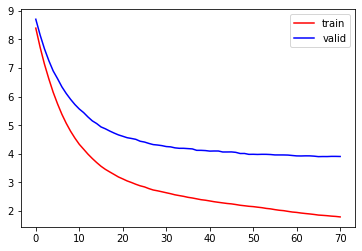

In [6]:
plt.plot(dict_evals_result["training"]["rmse"], color="red", label="train")
plt.plot(dict_evals_result["valid_1"]["rmse"], color="blue", label="valid")
plt.legend()
plt.show()

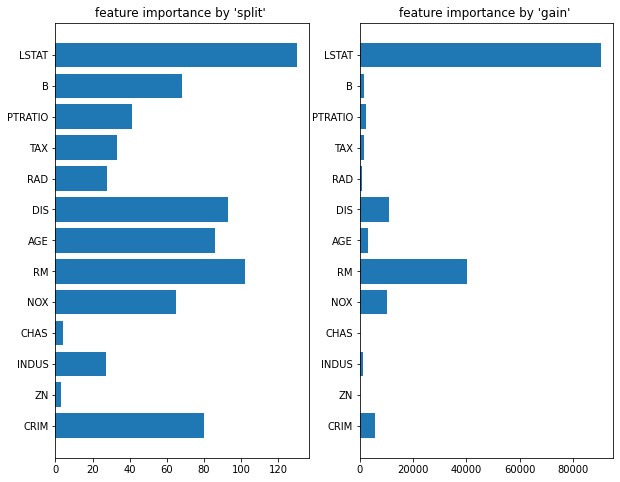

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 8))
for i, method in enumerate(["split", "gain"]):
    importance = model.feature_importance(importance_type=method)
    importance_df = pd.DataFrame({"imoportance":importance})
    axs[i].barh(width=importance, y=X.columns)
    axs[i].set_title(f"feature importance by '{method}' ")

plt.show()

## with KFold

Training until validation scores don't improve for 5 rounds
[10]	training's rmse: 4.54663	valid_1's rmse: 5.72058
[20]	training's rmse: 3.18802	valid_1's rmse: 4.6596
[30]	training's rmse: 2.67034	valid_1's rmse: 4.28373
[40]	training's rmse: 2.37461	valid_1's rmse: 4.11099
[50]	training's rmse: 2.16227	valid_1's rmse: 3.97863
[60]	training's rmse: 1.96134	valid_1's rmse: 3.93859
[70]	training's rmse: 1.8071	valid_1's rmse: 3.9074
Early stopping, best iteration is:
[66]	training's rmse: 1.85508	valid_1's rmse: 3.89916
Training until validation scores don't improve for 5 rounds
[10]	training's rmse: 4.65054	valid_1's rmse: 4.51891
[20]	training's rmse: 3.15432	valid_1's rmse: 3.97461
[30]	training's rmse: 2.61841	valid_1's rmse: 3.80239
[40]	training's rmse: 2.30188	valid_1's rmse: 3.71707
[50]	training's rmse: 2.09473	valid_1's rmse: 3.66213
[60]	training's rmse: 1.92986	valid_1's rmse: 3.59256
[70]	training's rmse: 1.81202	valid_1's rmse: 3.58896
[80]	training's rmse: 1.7045	valid_1's

/Users/ryotaro.shimizu/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


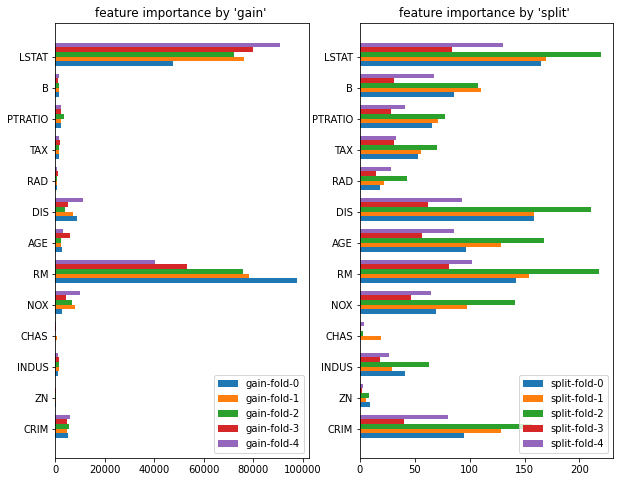

In [8]:
folds = KFold(n_splits=N_FOLD, shuffle=True, random_state=RANDOM_SEED)
fold_iter = folds.split(X, y=y)
height = 0.15
labels = X.columns
fig, axs = plt.subplots(ncols=2, figsize=(10, 8))
left = np.arange(len(labels), dtype=float) - height

for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
    X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_valid = y[trn_idx], y[val_idx]

    train_set = lgb.Dataset(X_train, y_train)
    valid_set = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params = {
            "objective":"regression",
            "metric":"rmse",
            "verbosity": -1,
        },
        train_set = train_set,
        valid_sets = [train_set, valid_set],
        num_boost_round = 100,
        early_stopping_rounds = 5,
        verbose_eval = 10,
    )
    
    for i, method in enumerate(["gain", "split"]):
        importances = list(model.feature_importance(importance_type=method))
        bar = axs[i].barh(left, importances, height=height, align='center', label=f"{method}-fold-{n_fold}")
        axs[i].bar_label(bar, label_type='center', fmt='')
        axs[i].legend()
        axs[i].set_title(f"feature importance by '{method}' ")
        axs[i].set_yticks(left-(height*N_FOLD)/2)
        axs[i].set_yticklabels(labels)
        
    left += height

fig.show()